# Seminar plan

In this notebook we will:

    1. Implement variational optimization:
        - and find even more pitfalls in "theoretically nicely working" methods;
    2. Look at ADVI
    3. Rat tumor examination

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
import pyro
from pyro import distributions as distrs
import seaborn as sns
import numpy.testing as np_testing

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

In [2]:
def sample(d: distrs.Distribution, num: int):
    """
    Sample from d samples with Pyro reparameterization capabilities
    """
    res = pyro.sample("dist", d.expand([num]))
    return res

## 1. Optimization of the synthetic function

We are going to optimize this function:

$$ f(x) = \log ((x - 0.35)^2 + 1) - 0.15 \exp(-10 |x - 0.8|)$$

In [3]:
def fun_from_lecture(x):
    """
    Some unknown synthetic function from the lecture
    """
    return (torch.log1p((x - 0.35) ** 2) - 0.15 * torch.exp(-10 * torch.abs(x - 0.8))).detach()

In [4]:
x = torch.linspace(0., 1., 1000)

In [5]:
plt.figure()
plt.plot(x, fun_from_lecture(x))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Some unknown synthetic function from the lecture')
plt.tight_layout()
plt.show()

In [6]:
def get_parameters_for_normal_dsitribution(mu=0., sigma=1., dim=2):
    """
    Creates trainable parameters for the normal distribution
    """
    train_mu = torch.Tensor(dim * [mu]).float().requires_grad_(True)
    train_sigma = (torch.eye(dim) * sigma).float().requires_grad_(True)
    return train_mu, train_sigma

def create_normal_distr(mu, sigma):
    """
    Given mu and sigma returns MultivariateNormal
    """
    return distrs.MultivariateNormal(mu, sigma)

In [7]:
mu, sigma = get_parameters_for_normal_dsitribution(dim=1)

## 1.1 Estimation of the variational bound

$\DeclareMathOperator*{\myE}{\mathop{\mathbb{E}}}$

##### In theory:

$$J(\psi) = \myE_{\theta \sim P(\cdot \,\mid\, \psi)} f(\theta) \to \min_\psi$$


##### In practice:

$$J(\psi) = \frac{1}{N} \sum\limits_{\theta \sim P(\cdot \,\mid\, \psi)} f(\theta) \to \min_\psi,$$

where the choice of $N$ depends only on your resources and availability of $f(\cdot)$.

In [8]:
from typing import Callable, List
def estimage_variational_bound(fun: Callable, create_dist: Callable, parameters: List[torch.Tensor], num_samples=5):
    """
    fun: function for which you want to estimate variational bound 
    create_dist: function that takes list of parameters and returns pyro distribution
    parameters: parameters of the distribution, that you will pass to create dist function
    num_samples: number of samples used to evaluate var bound
    
    var_bound: 
    """
    ### BEGIN SOLUTION
    dist = create_dist(*parameters)
    samples = sample(dist, num_samples).detach()
    var_bound = fun(samples).mean()
    ### END SOLUTION
    return var_bound

In [9]:
mu = torch.tensor([0.])
sigma = torch.tensor([[1.]])
num_samples = 100
res = [estimage_variational_bound(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
) for _ in range(100)]

assert 0.56 - 0.06 * 7 < torch.stack(res).mean() < 0.56 + 0.06 * 7, "It should be impossible..."
assert 0.06 - 0.005 * 7 < torch.stack(res).std() < 0.06 + 0.005 * 7, "That's also should be impossible, it's 7 sigma!"

mu = torch.tensor([0.8])
sigma = torch.tensor([[0.01]])
num_samples = 100000000
res = estimage_variational_bound(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=res.item(), desired=0.1114, significant=2)


mu = torch.tensor([0.3])
sigma = torch.tensor([[0.02]])
num_samples = 100000000
res = estimage_variational_bound(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=res.item(), desired=0.01907, significant=2)

### Let's plot some variational bounds!

In [12]:
from collections import defaultdict
num_samples = 100

sigma_plots = defaultdict(list)
mus = torch.linspace(0., 1., 100).view(-1, 1)

for sigma in tqdm(torch.tensor([0.01, 0.05, 0.1, 0.2]).view(-1, 1, 1).pow(2)):
    for mu in mus:
        sigma_plots[sigma.sqrt().item()].append(
            estimage_variational_bound(
                fun=fun_from_lecture,
                create_dist=create_normal_distr,
                parameters=[mu, sigma],
                num_samples=num_samples
            )
        )
for sigma in sigma_plots:
    sigma_plots[sigma] = torch.stack(sigma_plots[sigma])

100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


In [13]:
for sigma in sigma_plots:
    plt.plot(mus, sigma_plots[sigma], label=r"$\sigma={:.4}$".format(sigma))
plt.legend()
plt.plot(x, fun_from_lecture(x))

![Moar samples](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/moar_samples.jpg)

## 1.2 Now we are going to estimate the gradient of the variational bound

In theory:

$$\nabla_\psi J(\psi) = \myE_{\theta \sim P(\cdot\mid\psi)} f(\theta)\; \nabla_\psi \log P(\theta\mid\psi)$$

In practice:

$$\nabla_\psi J(\psi) = \frac{1}{N} \sum\limits_{\theta \sim P(\cdot \,\mid\, \psi)}  f(\theta)\; \nabla_\psi \log P(\theta\mid\psi)$$



In [14]:
from torch import autograd

def estimage_variational_grad(fun: Callable, create_dist: Callable, parameters: List[torch.Tensor], num_samples=5):
    """
    fun: function for which you want to estimate variational bound 
    create_dist: function that takes list of parameters and returns pyro distribution
    parameters: parameters of the distribution, that you will pass to create dist function
    num_samples: number of samples used to evaluate var bound
    
    grads: list of torch tensors with the same shape as 
    """
    ### BEGIN SOLUTION
    parameters = [p.requires_grad_(True) for p in parameters]
    dist = create_dist(*parameters)
    samples = sample(dist, num_samples).detach()
    fun_values = fun(samples).view(-1)
    grads = autograd.grad((fun_values * dist.log_prob(samples)).mean(), parameters)
    ### END SOLUTION
    return grads

In [15]:
num_samples = 100000000

mu = torch.tensor([0.8])
sigma = torch.tensor([[0.01]])
grad = estimage_variational_grad(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=grad[0].item(), desired=0.73411, significant=2)
np_testing.assert_approx_equal(actual=grad[1].item(), desired=2.568, significant=2)


mu = torch.tensor([0.2])
sigma = torch.tensor([[0.04]])
grad = estimage_variational_grad(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=grad[0].item(), desired=-0.28668, significant=2)
np_testing.assert_approx_equal(actual=grad[1].item(), desired=0.75752, significant=2)

## 1.3 Optimization!

Do not look here, just some data for some plots...

In [17]:
num_samples = 1000

mu_grid = np.linspace(0, 1, num=21)
sigma_grid = np.linspace(0, 0.5, num=21)[1:]

Mu, Sigma = np.meshgrid(mu_grid, sigma_grid,)

dJ_dmu = np.zeros(shape=(mu_grid.shape[0], sigma_grid.shape[0]))
dJ_dsigma = np.zeros(shape=(mu_grid.shape[0], sigma_grid.shape[0]))

for i, mu in tqdm(enumerate(mu_grid)):
    for j, sigma in enumerate(sigma_grid):
        grads = estimage_variational_grad(
            fun=fun_from_lecture,
            create_dist=create_normal_distr,
            parameters=[torch.tensor(mu).view(1), torch.tensor(sigma).pow(2).view(1, 1)],
            num_samples=num_samples
        )
        dJ_dmu[i, j], dJ_dsigma[i, j] = grads[0].item(), grads[1].item()

21it [00:06,  3.03it/s]


In [26]:
def plot_optimization_path():
    fig = plt.figure(figsize=(9, 9), constrained_layout=True, dpi=100)
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])

    ax1 = fig.add_subplot(gs[0, 0])
    for sigma in sigma_plots:
        plt.plot(mus, sigma_plots[sigma], label=r"$\sigma={:.4}$".format(sigma))

    fig.add_subplot(gs[1, 0], sharex=ax1)

    plt.vlines([0.35, 0.8], ymin=0, ymax=sigma_grid[-1], lw=2, linestyles='--', color=plt.cm.tab10(1), alpha=0.75)
    plt.quiver(mu_grid, sigma_grid, -dJ_dmu.T, -dJ_dsigma.T, angles='xy')

    plt.ylim([0, sigma_grid[-1]])
    plt.xlim([mu_grid[0], mu_grid[-1]])

    plt.xlabel(r'$\mu$');
    plt.ylabel(r'$\sigma$');

### Optimization!

1. Initialize parameters $\mu$ and $\sigma$

In [34]:
mu, sigma = get_parameters_for_normal_dsitribution(mu=0.95, sigma=0.5, dim=1)

2. Get your favorite optimizer ready

In [35]:
opt = torch.optim.SGD([mu, sigma], lr=1e-2)

3. Optimization start!

In [36]:
epochs = 1000
num_samples = 100
eps = 1e-2
hist = defaultdict(list)

for epoch in tqdm(range(epochs)):
    sigma.data.clamp_(eps)
    grad_mu, grad_sigma = estimage_variational_grad(
        fun=fun_from_lecture, 
        create_dist=create_normal_distr, 
        parameters=[mu, sigma], 
        num_samples=num_samples
    )
    hist["mu"].append(mu.item())
    hist["sigma"].append(sigma.item())
    
    hist["grad_mu"].append(grad_mu.item())
    hist["grad_sigma"].append(grad_sigma.item())

    hist["fun"].append(
        estimage_variational_bound(
            fun=fun_from_lecture, 
            create_dist=create_normal_distr, 
            parameters=[mu, sigma], 
            num_samples=100000
        ).item()
    )
    
    opt.zero_grad()
    # GOSH! We didn't backprop between `opt.zero_grad()` and `opt.step()`
    mu.grad = grad_mu.data
    sigma.grad = grad_sigma.data
    opt.step()
    sigma.data.clamp_(eps)
    
    if epoch % 100 == 0:
        clear_output(wait=True)
        fig = plt.figure(figsize=(9, 9), constrained_layout=True, dpi=100)
        gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])

        ax1 = fig.add_subplot(gs[0, 0])
        for sigma_tmp in sigma_plots:
            plt.plot(mus, sigma_plots[sigma_tmp], label=r"$\sigma={:.4}$".format(sigma_tmp))
        plt.scatter(hist['mu'], fun_from_lecture(torch.tensor(hist['mu'])), c='r')

        fig.add_subplot(gs[1, 0], sharex=ax1)

        plt.vlines([0.35, 0.8], ymin=0, ymax=sigma_grid[-1], lw=2, linestyles='--', color=plt.cm.tab10(1), alpha=0.75)
        plt.quiver(mu_grid, sigma_grid, -dJ_dmu.T, -dJ_dsigma.T, angles='xy')
        plt.scatter(hist['mu'], hist['sigma'], c='r')

        plt.ylim([0, sigma_grid[-1]])
        plt.xlim([mu_grid[0], mu_grid[-1]])

        plt.xlabel('$\\mu$');
        plt.ylabel('$\\sigma$');
        plt.show()

100%|██████████| 1000/1000 [00:23<00:00, 42.72it/s]


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

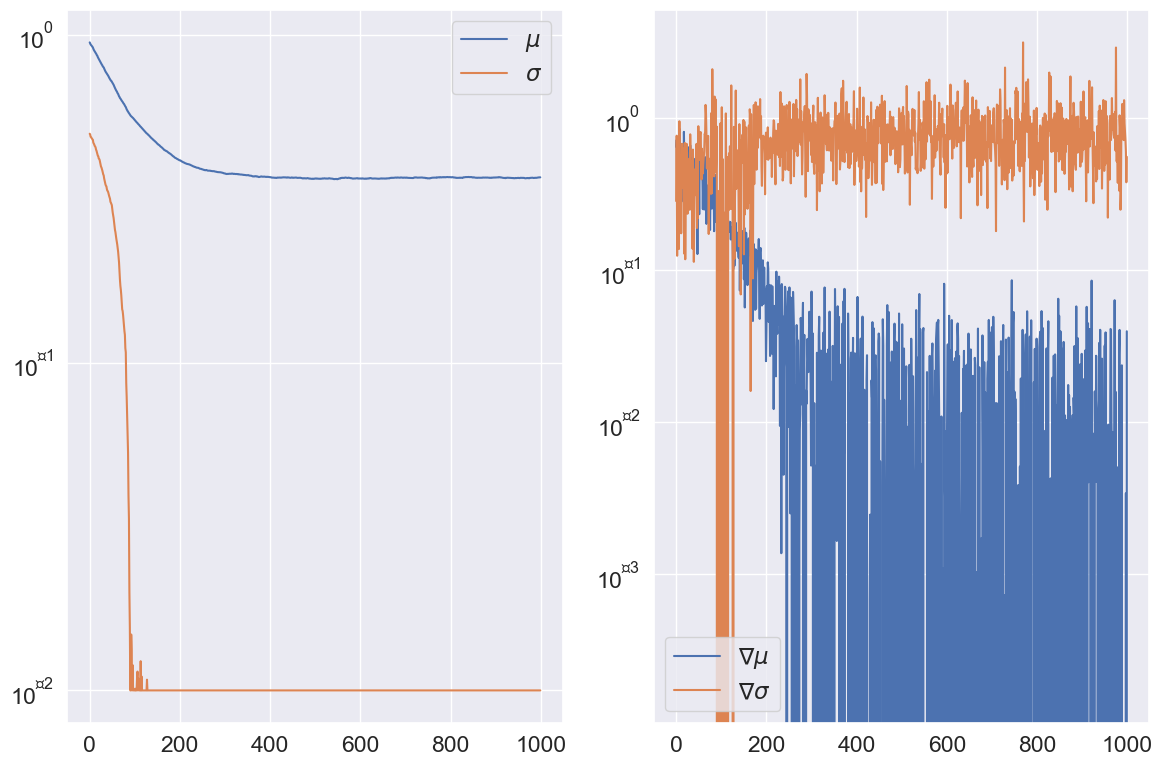

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), dpi=100)
axes[0].plot(hist['mu'], label=r'$\mu$')
axes[0].plot(hist['sigma'], label=r'$\sigma$')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(hist['grad_mu'], label=r'$\nabla \mu$')
axes[1].plot(hist['grad_sigma'], label=r'$\nabla \sigma$')
axes[1].set_yscale('log')
axes[1].legend()
fig.tight_layout()

### If you observe something strange during optimization try to change parameter in `sigma.data.clamp_`

### Lesson: gradients are not stable

$$\nabla_{\mu} J(\mu, \sigma) = f(x) \frac{x - \mu}{\sigma^2} \propto \frac{1}{\sigma}$$

$$\nabla_{\sigma} J(\mu, \sigma) = f(x) \frac{(x - \mu)^2 - \sigma^2}{\sigma^2} \propto \frac{1}{\sigma}$$

So it is possible that gradients are going to oscillate.

![Gradient instability](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/gradient_instability.png)